# Reinforcement Learning

__UNDER CONSTRUCTION__


_I have not failed. I’ve just found 10,000 ways that won’t work_ - Thomas A. Edison

References:

- Richard S. Sutton and Andrew G. Barto, 2018, "Reinforcement Learning: An Introduction", MIT Press.
- Christine Benz, Jeffrey Ptak John Rekenthaler, Dec. 12, 2022, "The State of Retirement Income: 2022. A look at how higher bond yields, lower equity valuations, and inflation affect starting safe withdrawal rates", Morningstar Portfolio and Planning Research.


TODO:
- shortfall tail probability:
  (1) probability of shortfall
  (2) expected years of shortfall in 5% tail
- for historical simulation, save matrices to compare: does one model's matrix dominate another 


In [1]:
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from typing import List, Tuple
from finds.database import SQL
from finds.structured import BusDay
from finds.utils import Store, subplots, set_xticks
from secret import credentials, paths
store = Store(paths['scratch'])
#pd.set_option('display.max_rows', None)
VERBOSE = 0

In [2]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
bd = BusDay(sql, verbose=VERBOSE)
outdir = paths['scratch'] / 'RL'

Stocks, Bonds, Bills and Inflation

Using data beginning in 1926, the SBBI dataset includes monthly,
quarterly, and yearly total returns and yields of most of the major
U.S asset classes: large-cap stocks, small-cap stocks, corporate
bonds, government bonds of several maturities, and inflation.


In [3]:
# Read sbbi data
sbbi_file = paths['data'] / 'SBBI/stocks-bonds-bills-and-inflation-data.xlsx'
df = pd.read_excel(sbbi_file,
                   sheet_name=0,
                   skiprows=list(range(9)) + [10],
                   header=0,
                   usecols='A,B,G,P',
                   index_col=0)
columns_official = df.columns.tolist()
df.columns = ['stocks', 'bonds', 'inflation']
df.index = bd.to_date(df.index)
df

,stocks,bonds,inflation
19260131,0.000000,0.013756,0.000000
19260228,-0.038462,0.006313,0.000000
19260331,-0.057471,0.004129,-0.005587
19260430,0.025305,0.007589,0.005618
19260531,0.017918,0.001412,-0.005587
...,...,...,...
20230228,-0.024399,-0.042743,0.005582
20230331,0.036714,0.042510,0.003311
20230430,0.015609,0.012058,0.005059
20230531,0.004347,-0.030476,0.002518


In [4]:
# Scenario generator: episode, backtest a sample path
class Episodes:
    def __init__(self, data: DataFrame, T: int, num_loops: int = 1):
        self.data = np.log(1 + data)
        self.high = list(self.data.max() + self.data.std()*.1)
        self.low = list(self.data.min() - self.data.std()*.1)
        self.T = T              # number of years per episode
        self.M = (T + 1) * 12   # number of monthly observations per episode
        self.num_loops = num_loops

    def __len__(self):
        return (len(self.data) - self.M + 1) * self.num_loops
        
    def __iter__(self):
        rows = []
        for i in range(self.num_loops):
            rows += np.random.permutation(len(self.data) - self.M + 1).tolist()
        for t in rows:
            df = self.data.iloc[t:(t + self.M), :].reset_index(drop=True)
            yield df.groupby(df.index // 12)\
                    .sum()\
                    .set_index(self.data.index[(t + 11):(t + self.M):12])

Summary statistics of episodes


In [5]:
T = 30
means = {s: [] for s in df.columns}
episodes = Episodes(df, T=T)
for episode in iter(episodes):
    for s in df.columns:
        means[s].append(episode[s].mean())
print('30-year sample periods:')
DataFrame({s: np.mean(x) for s, x in means.items()} | {'N': len(episodes)},
          index=['annualized mean'])

30-year sample periods:


,stocks,bonds,inflation,N
annualized mean,0.105343,0.055095,0.036288,799


## Retirement spending policy

We test the sensitivity of the common heuristic for retirement spending, a fixed annual withdrawal rate, on models driven by three key variables: the asset allocation of the portfolio, the market environment, and the length of the retiree's drawdown period. For example, the typical rule of a fixed 4% withdrawal rate (with annual inflation adjustment) for 50% stock/50% bond portfolios can be evaluated over rolling historical 30-year periods, to estimate the likelihood that a retiree would not run out of money over a 30-year time horizon.

Benz, Ptak and Rekenthaler (2022) found that "For retirees who seek a fixed real withdrawal from their portfolio in retirement, a starting withdrawal rate of 3.8% is safe in Morningstar’s model over a 30-year time horizon, assuming a 90% success rate (defined here as a 90% likelihood of not running out of funds) and a balanced portfolio."

The default strategy is to rebalance each year to fixed initial allocation, and withdrawal is fixed at the given percent of initial wealth adjusted by annual inflation. 


In [6]:
class BaseModel:
    """Buy-and-hold allocation model where assets weights drift from initial"""
    
    name = 'intial'
    def __init__(self, T: int, W: List[float]):
        assert W[-1] > 0         # spend must be positive
        self.initial = dict(T=int(T), W=np.array(W))
        
    def reset(self, market_changes: List[float]):
        self.T = int(self.initial["T"])
        self.W = np.array(self.initial["W"])
        return list(market_changes)

    def step(self, action: List, market_changes: List) -> Tuple:
        assert self.T > 0
        self.W[:-1] = np.array(action).flatten() * self.W[:-1].sum() # rebalance
        self.W = self.W * np.exp(np.array(market_changes))           # price changes
        self.T = self.T - 1
        wealth = sum(self.W[:-1])  # remaining wealth
        if wealth < self.W[-1]:
            truncated = True          # is not enough for spend  
            self.W[:-1] = 0.0            
        else:                 
            truncated = False         # is sufficient for spend
            spend = self.W[-1] * self.W[:-1] / wealth  # allocate and deduct spending
            self.W[:-1] = self.W[:-1] - spend
        terminated = not self.T or truncated
        return terminated, truncated

    def predict(self, obs: List) -> List:
        """Allow initial asset allocation to drift"""
        return self.W[:-1] / sum(self.W[:-1])

In [7]:
class FixedModel(BaseModel):
    """Allocation model where assets are rebalanced to fixed weights"""
    
    name = 'fixed'
    def predict(self, obs: List) -> List:
        """Action to rebalance asset allocation to fixed initial weight"""
        return self.initial['W'][:-1] / sum(self.initial['W'][:-1])

Base simulations of 50-50 4% spending policy over all 30-year sample periods

In [8]:
alloc = 50   # 50-50 stocks/bonds initial allocation
rule = 4.0   # 4 percent spending policy
model = BaseModel(T=T, W=[alloc, 100-alloc, rule])

In [9]:
result = {}
for n, episode in enumerate(iter(episodes)):
    obs = model.reset(episode.iloc[0])

    for year in episode.index[1:]:
        obs = episode.loc[year].to_list()
        action = model.predict(obs)
        terminated, truncated = model.step(action, obs)
        if truncated:
            break
    result[episode.index[0]] = model.T
prob = np.mean(np.array(list(result.values())) != 0)
print('Number of 30-year scenerios:', len(episodes))
print('Probability of shortfall:   ', round(prob, 4))

Number of 30-year scenerios: 799
Probability of shortfall:    0.0763


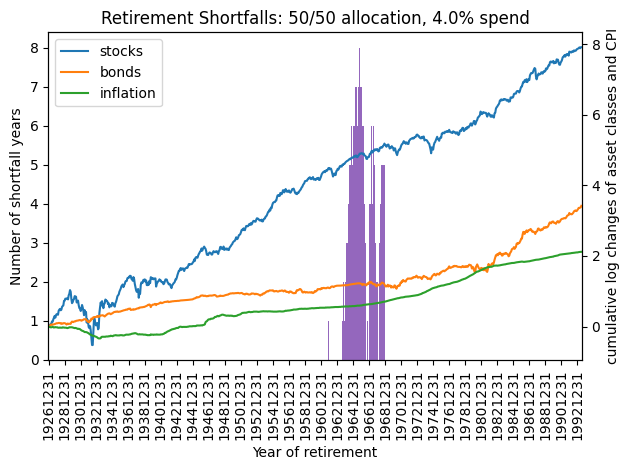

In [10]:
fails = Series(result).sort_index().rename('shortfall_years')
market = df.reindex(fails.index).cumsum()
fails.index = fails.index.astype(str)
ax = fails.plot(kind='bar', width=1.0, color='C4')
ax.set_title(f"Retirement Shortfalls: {alloc}/{100-alloc} allocation, {rule}% spend")
ax.set_ylabel('Number of shortfall years')
ax.set_xlabel('Year of retirement')
set_xticks(ax=ax, nskip=23, rotation=90)
bx = ax.twinx()
market.index = market.index.astype(str)
market.plot(ax=bx)
bx.set_ylabel('cumulative log changes of asset classes and CPI')
bx.legend()
plt.tight_layout()

## Deep reinforcement learning

`Gymnasium` (formerly OpenAI gym) custom environment
__Gymnasium__ provides a simply and pythonic interface for representing general Reinforcement Learning problems.  It is a maintained fork of OpenAI’s Gym library.

https://gymnasium.farama.org/index.html

`pip install gymnasium`

__Stable Baselines3 (SB3)__ is a set of implementations of reinforcement learning algorithms in PyTorch.

https://github.com/DLR-RM/stable-baselines3

`pip install stable-baselines3[extra]`


Reward is -(T*T*FAIL) if truncated else math.sqrt(W / (S*(T+1)))
- if insufficient: reward is -100 times square of remaining years
-  else reward is a concave (sqrt) function of wealth to spending coverage
-  when positive, prefer that wealth to remaining spending ratio is higher

Learns to predict action from observing current state, and exploiting/exploring
- current wealth and allocation,
- recent market (equity and bonds) and inflation changes
- spending amount
- years since retirement

Exploit action with greatest expected value
-  value is recursive expectation: many algorithms e.g. "Q-learning", "SARSA"

Explore actions that are not necessarily best (at the time) during training
- to gather information for improving decision


In [11]:
FAIL = 100    # failure reward factor
class CustomEnv(gym.Env):
    """Custom gymnasium environment, using Episodes scenario generator"""
    def __init__(self, model: BaseModel, episodes: Episodes):
        super().__init__()
        self.model = model            # for stepping through a 30-year episode
        self.episodes = episodes      # for generating a sample 30-year episode
        self.iterator = iter(self.episodes)  # iterator to reset a 30-year sample
        T = self.model.initial['T']
        W = self.model.initial['W']
        low = np.array([0] + episodes.low + [0]*len(W))
        high = np.array([T] + episodes.high + [T]*len(W))
        self.observation_space = spaces.Box(low=low, high=high)
        self.action_space = spaces.Discrete(21)
        #self.action_space = spaces.Box(low=0.0, high=1.0)
        
    def reset(self, seed=0):
        super().reset(seed=seed)

        # generate a fresh 30-year episode
        self.episode = next(self.iterator, None)
        if self.episode is None:
            self.iterator = iter(self.episodes)
            self.episode = next(self.iterator)
        self.n = 0

        # return initial observations
        deltas = self.model.reset(self.episode.iloc[self.n])
        obs = [self.model.T] + list(deltas) + self.model.W.tolist()
        return obs, {}


    def step(self, action):
        S = self.model.W[-1]            # amount to spend at t-1
        W = np.sum(self.model.W[:-1])   # wealth at t-1
        T = self.model.T                # year remaining till termination

        # Convert action to asset allocation weights
        action = action * 0.05
        action = np.array([action, 1-action])
        
        # Grab next market move at time t
        self.n = self.n + 1
        deltas = self.episode.iloc[self.n].tolist()

        # Apply rebalance wealth and market move (t=1)
        terminated, truncated = self.model.step(action, deltas)

        # Calculate reward (t=1)
        reward = -(T*T*FAIL) if truncated else math.sqrt(W / (S*T))

        # Return as next observation
        obs = [T] + list(deltas) + self.model.W.tolist()
        return obs, reward, terminated, truncated, {}

Helpers to evaluate trained model

In [12]:
def compute_shortfall(x, q):
    """Compute expected years of shortfall given probability level"""
    x = sorted(x)
    q = int(q * len(x))
    return x[q], np.mean(x[q:])

In [13]:
TAIL = 0.95
def evaluate(env, model, episodes):
    """Return success likelihood, shortfalls and asset allocation actions"""
    result = []
    actions = {t: [] for t in range(episodes.T + 1)}  # to store predicted actions
    for n, episode in enumerate(iter(episodes)):
        obs, info = env.reset()
        terminated = False
        while not terminated:
            action, _states = model.predict(np.array(obs))
            actions[env.model.T].append(float(action))
            obs, rewards, terminated, truncated, info = env.step(action)
        result.append(env.model.T if truncated else 0)
    #print(n, truncated, action, rewards, env.model.W)
    return np.mean(np.array(result) != 0), *compute_shortfall(result, TAIL), actions

__Stable Baselines 3__ with __DQN__ algorithm for discrete action spaces

`DQN` (Deep Q Network) provides vanilla Deep Q-Learning

In [14]:
initial_alloc = 50
rules = np.arange(3, 5.1, 0.1)

In [15]:
TIMESTEPS = int(5e5)
fail, actions, shortfall, quantile = {}, {}, {}, {}
for rule in tqdm(rules):  # train a model for each spending rule

    # define and train model for this spending rule
    name = str(round(rule, 1))
    W = [initial_alloc, 100-initial_alloc, rule]
    env = CustomEnv(model=BaseModel(T=T, W=W), episodes=episodes)
    clf = DQN('MlpPolicy', env, verbose=VERBOSE)
    clf.learn(total_timesteps=TIMESTEPS)
    clf.save(f"{outdir}/{name}")

    # evaluate model
    test_clf = clf.load(f"{outdir}/{name}", env=None)
    fail[name], quantile[name], shortfall[name], actions[name] =\
        evaluate(env, test_clf, episodes)

    store['dqn'] = dict(fail=fail, shortfall=shortfall,
                        quantile=quantile, actions=actions)

  0%|          | 0/21 [00:00<?, ?it/s]/home/terence/env3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 21/21 [1:42:19<00:00, 292.37s/it]


In [16]:
print(DataFrame(fail, index=["Deep RL"]).round(2).to_string())

         3.0  3.1   3.2  3.3  3.4   3.5   3.6   3.7   3.8   3.9   4.0   4.1   4.2   4.3   4.4   4.5   4.6   4.7   4.8   4.9   5.0
Deep RL  0.0  0.0  0.02  0.0  0.0  0.01  0.01  0.01  0.02  0.01  0.03  0.03  0.05  0.07  0.08  0.12  0.13  0.14  0.14  0.18  0.19


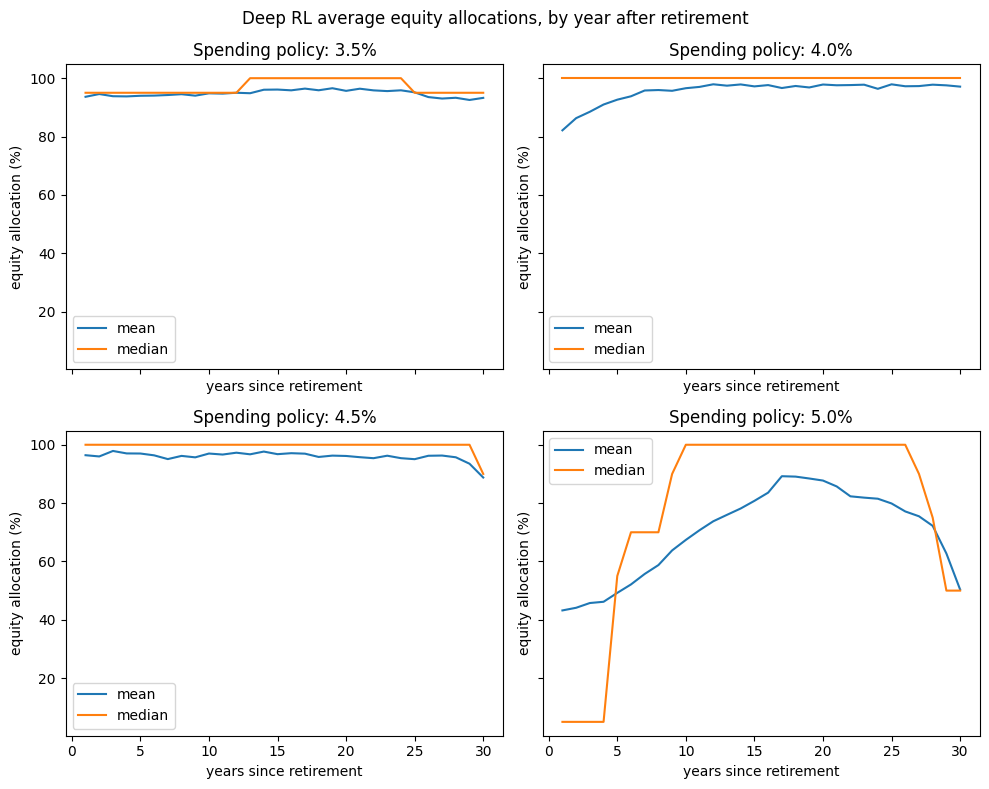

In [17]:
# Plot average allocations over time
labels = list(np.arange(T) + 1)
fig, axs = subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)
plt.suptitle('Deep RL average equity allocations, by year after retirement')
for ax, rule in zip(axs, ["3.5", "4.0", "4.5", "5.0"]):
    y = [[a*5 for a in actions[rule][i]] for i in labels]
    mean = [np.mean(a) for a in y]
    median = [np.median(a) for a in y]
    ax.plot(labels, mean, label='mean')
    ax.plot(labels, median, label='median')
    ax.set_title(f"Spending policy: {rule}%")
    ax.set_xlabel('years since retirement')
    ax.set_ylabel('equity allocation (%)')
    ax.legend()
plt.tight_layout()

### Historical simulations
Extended grid of simulations,
by asset allocation target and spending withdrawal rate


In [18]:
# simulate fixed and initial equity allocations from 0 to 100%
allocs = np.arange(0, 105, 5)
for num, Model in enumerate([BaseModel, FixedModel]):
    fail = DataFrame(columns=rules, index=allocs, dtype=float)
    shortfall = DataFrame(columns=rules, index=allocs, dtype=float)
    quantile = DataFrame(columns=rules, index=allocs, dtype=float)

    for alloc in tqdm(allocs):
        for rule in rules:

            # Evaluate for this allocation strategy and spending policy
            model = Model(T=T, W=[alloc, 100-alloc, rule])
            result = []
            for n, episode in enumerate(iter(episodes)): # for every 30-year sample
                obs = model.reset(episode.iloc[0])
                for year in episode.index[1:]:
                    obs = episode.loc[year].to_list()
                    action = model.predict(obs)
                    terminated, truncated = model.step(action, obs)
                    if truncated:
                        break
                result.append(model.T)
            fail.loc[alloc, rule] = np.mean(np.array(result) != 0)
            quantile.loc[alloc, rule], shortfall.loc[alloc, rule] =\
                compute_shortfall(result, TAIL)
    store[model.name] = dict(fail=fail, shortfall=shortfall)

100%|██████████| 21/21 [06:54<00:00, 19.74s/it]


TODO: Heatmap with (numbers)

In [19]:
def plot_contour(Z, levels, title, label):
    """Helper to plot contour lines at given levels"""
    X, Y = np.meshgrid(rules, allocs)
    fig, ax = plt.subplots(figsize=(10, 6))
    cp = ax.contour(X, Y, Z, levels=levels, cmap='cool')
    ax.set_title(f"{title}, with {model.name} asset allocation")
    ax.set_xticks(rules)
    ax.set_xlabel('spending policy (%)')
    ax.set_yticks(allocs)
    ax.set_ylabel(f'{model.name} equity allocation (%)')
    ax.grid(which='both')
    fig.colorbar(cp, label=label)
    plt.tight_layout()

In [20]:
tail = int(100 * (1 - TAIL))
for model in [BaseModel, FixedModel]:
    fail = store[model.name]['fail']
    print(f"Probability of Shortfall: with {model.name} allocation")
    print(fail.iloc[::-1, :].round(2).to_string())

Probability of Shortfall: with intial allocation
      3.0   3.1   3.2   3.3   3.4   3.5   3.6   3.7   3.8   3.9   4.0   4.1   4.2   4.3   4.4   4.5   4.6   4.7   4.8   4.9   5.0
100  0.00  0.00  0.00  0.00  0.00  0.01  0.01  0.01  0.02  0.02  0.02  0.03  0.05  0.07  0.08  0.10  0.11  0.12  0.13  0.15  0.17
95   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01  0.01  0.01  0.03  0.04  0.06  0.07  0.08  0.10  0.10  0.12  0.14  0.16  0.17
90   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01  0.02  0.04  0.06  0.08  0.09  0.10  0.11  0.12  0.14  0.16  0.18
85   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01  0.02  0.04  0.06  0.08  0.09  0.10  0.12  0.13  0.15  0.17  0.18
80   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01  0.02  0.05  0.06  0.07  0.09  0.10  0.12  0.14  0.16  0.17  0.19
75   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01  0.04  0.05  0.07  0.08  0.09  0.10  0.13  0.15  0.16  0.17  0.19
70   0.00  0.00  0.00  0.00  0.00  0.00  

In [21]:
compare = store[BaseModel.name]['fail'] < store[FixedModel.name]['fail']
print(compare.mean().mean())

0.3741496598639455


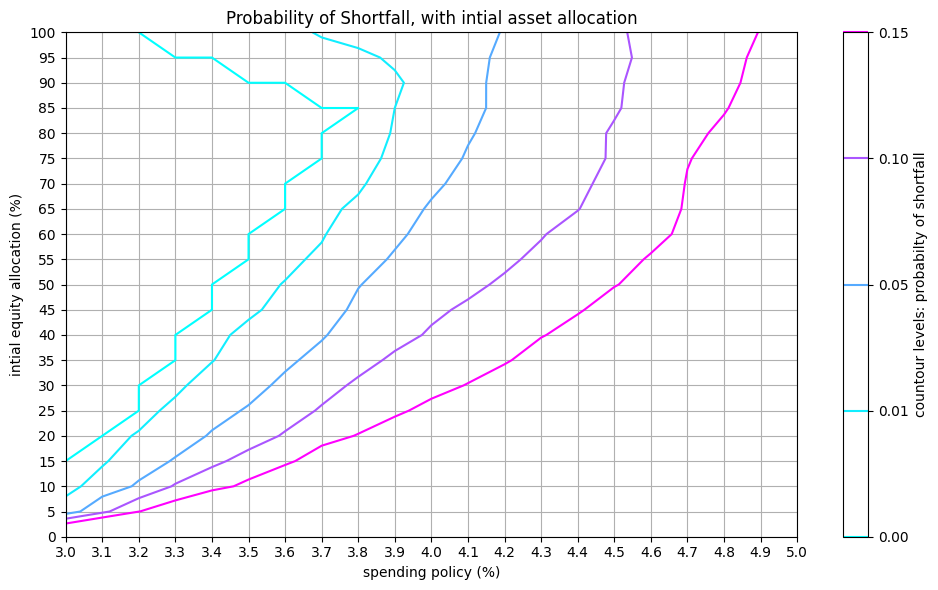

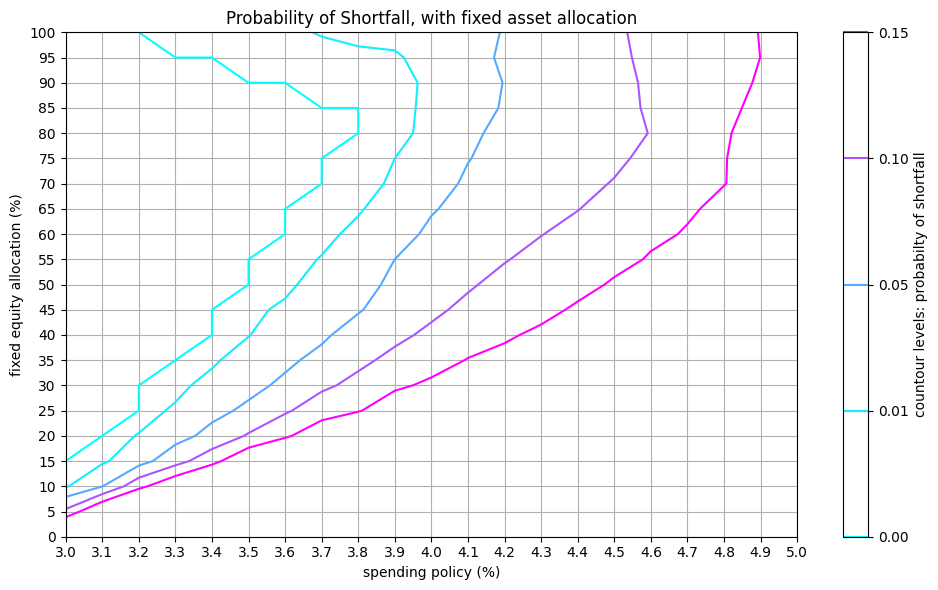

In [22]:
for model in [BaseModel, FixedModel]:    
    fail = store[model.name]['fail']
    plot_contour(fail, levels=[0.0, .01,.05,.1,.15],
                 title="Probability of Shortfall", 
                 label="countour levels: probabilty of shortfall")

In [23]:
for model in [BaseModel, FixedModel]:    
    shortfall = store[model.name]['shortfall']
    print(f"Expected Years of Shortfall in {tail}% tail: (model.name) allocation")
    print(shortfall.iloc[::-1, :].round(1).to_string())

Expected Years of Shortfall in 5% tail: (model.name) allocation
     3.0  3.1  3.2  3.3  3.4  3.5  3.6  3.7   3.8   3.9   4.0   4.1   4.2   4.3   4.4   4.5   4.6   4.7   4.8   4.9   5.0
100  0.0  0.0  0.0  0.1  0.3  0.6  0.8  1.2   1.8   2.5   3.1   4.1   5.8   7.1   8.2   9.3  10.1  11.0  11.6  12.4  12.9
95   0.0  0.0  0.0  0.0  0.0  0.1  0.2  0.4   0.7   1.1   2.1   3.2   5.0   6.3   7.6   8.7   9.6  10.4  11.0  11.6  12.2
90   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1   0.2   0.5   1.2   2.4   4.3   5.8   7.1   8.2   9.0   9.9  10.6  11.2  11.7
85   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.3   1.0   2.3   4.2   5.6   6.9   7.9   8.9   9.6  10.4  11.0  11.7
80   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.4   1.1   2.7   4.5   5.8   7.0   8.0   8.9   9.7  10.5  11.1  11.7
75   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.1   0.6   1.7   3.4   5.0   6.3   7.4   8.3   9.2  10.0  10.6  11.3  11.8
70   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.2   1.0   2.5   4.2   5.6   6.7   

In [24]:
compare = store[BaseModel.name]['shortfall'] < store[FixedModel.name]['shortfall']
print(compare.mean().mean())

0.058956916099773236


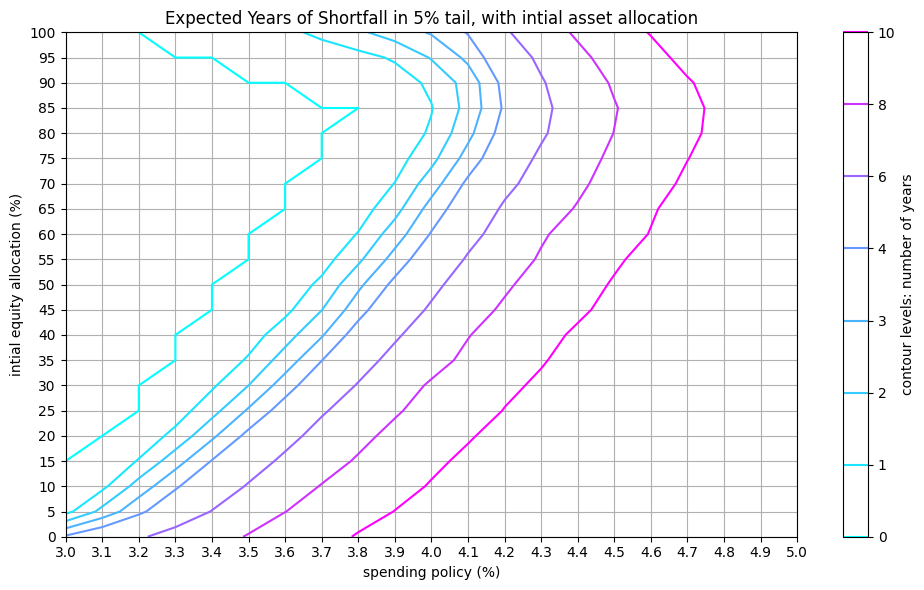

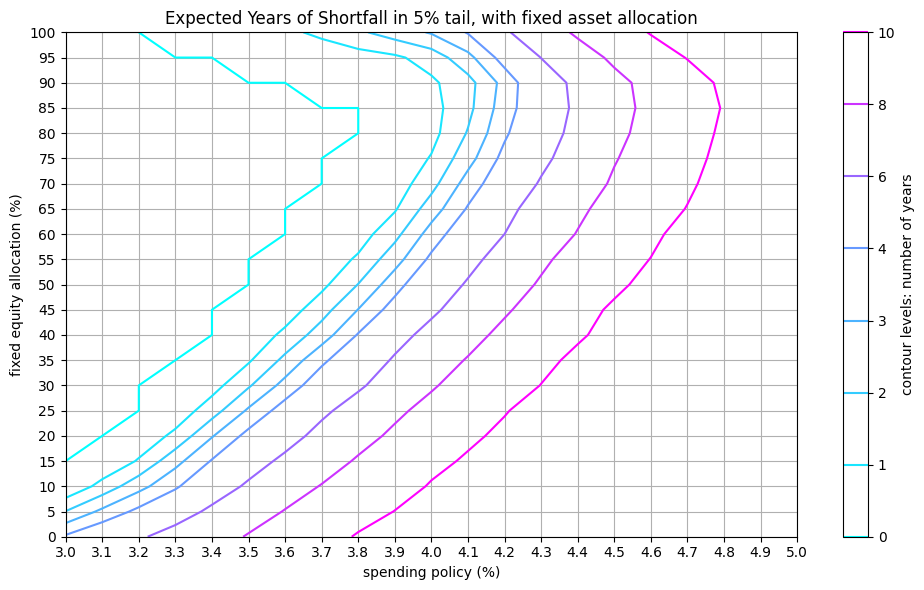

In [25]:
for model in [BaseModel, FixedModel]:    
    shortfall = store[model.name]['shortfall']
    plot_contour(shortfall, levels=[0, 1, 2, 3, 4, 6, 8, 10], 
                 title=f"Expected Years of Shortfall in {tail}% tail",
                 label="contour levels: number of years")